# Analysis using raw functions (not the MNE package)


## imports

In [222]:
import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from functional import seq
from scipy import signal
from itertools import combinations 
import mne

%matplotlib inline

In [4]:
if [int(i) for i in mne.__version__.split('.')] < [0, 20, 0]:
    print('should be at least 0.20.0')
    stop # this is the best hack, it clearly does what it is supposed to do

## helper functions

### computation

In [5]:
def bandpower(data, sf, band, method='welch', window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Requires MNE-Python >= 0.14.
    Source: https://raphaelvallat.com/bandpower.html

    Parameters
    ----------
    data : 1d-array
      Input signal in the time-domain.
    sf : float
      Sampling frequency of the data.
    band : list
      Lower and upper frequencies of the band of interest.
    method : string
      Periodogram method: 'welch' or 'multitaper'
    window_sec : float
      Length of each window in seconds. Useful only if method == 'welch'.
      If None, window_sec = (1 / min(band)) * 2.
    relative : boolean
      If True, return the relative power (= divided by the total power of the signal).
      If False (default), return the absolute power.

    Return
    ------
    bp : float
      Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    from mne.time_frequency import psd_array_multitaper
    

    band = np.asarray(band)
    low, high = band
    
    # Compute the modified periodogram (Welch)
    if method == 'welch':
        if window_sec is not None:
            nperseg = window_sec * sf
        else:
            nperseg = (2 / low) * sf

        if data.shape[0] < nperseg:
            return np.NaN
            
        
        freqs, psd = welch(data, sf, nperseg=nperseg)

    elif method == 'multitaper':
        psd, freqs = psd_array_multitaper(data, sf, adaptive=True,
                                          normalization='full', verbose=0)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find index of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using parabola (Simpson's rule)
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
        
    return bp

In [6]:
def get_bandpower_for_electrode(signal_data, electrode, bands, sampling_frequenc=300, window_size='1s'):
    """Calculates the bandpower with a rolling window for the given electrode
    
    Note that this will take some time... I suggest that you only use a part of the signal to try it out.
    
    Parameters
    ----------
    signal_data: 2d pandas dataframe
        raw signal data, indexed by a timedeltaindex (or any other time-based index)
    electrode: string
        name of the electrode of interest
    config: dict
        dict of config parameters
    window_size: string
        size of rolling window
        
    Returns
    -------
    a new pandas dataframe of the bandpowers, in addition all ration combinations are listed as well
    """
    bandpowers = {}

    for band_name, band_range in bands.items():
        bandpowers[band_name] = signal_data.loc[:, electrode]\
            .rolling(window_size)\
            .apply(lambda xs: bandpower(xs, sampling_frequency, band_range))

    # compute all different ratios
    for bn_l, bn_r in combinations(bands.keys(), 2):
        bandpowers[f"{bn_l} / {bn_r}"] = bandpowers[bn_l] / bandpowers[bn_r]
        
    return bandpowers 

In [7]:
def aggregate_bandpower(baseline, signal):
    aggregated_fns = ['mean', 'median', 'min', 'max']
    aggregated_power = pd.DataFrame(index=pd.MultiIndex.from_product([list(baseline.keys()), ['baseline', 'meditation']]),
                                    columns=aggregated_fns)

    for band, power in baseline.items():
        aggregated_power.loc[(band, "baseline"), :] = power.agg(aggregated_fns)


    for band, power in signal.items():
        aggregated_power.loc[(band, 'meditation'), :] = power.agg(aggregated_fns)


    return aggregated_power

### data loading

In [8]:
def load_signal_data(data_type, config, subject='sam', recording=0, remove_references=True):
    """loads the data and returns a pandas dataframe 
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
      
    Returns
    -------
    a pandas dataframe, timedeltaindexed of the raw signals
    """
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    data = pd.read_pickle(f"{config['paths']['base']}/{subject_paths['prefix']}/offline/{get_config_value(subject_paths, 'recordings', data_type)[recording]}-raw.pcl")
    
    _t = data['timestamps'].reshape(-1)
    _t -= _t[0]

    signal = pd.DataFrame(data=data['signals'], 
                          index=pd.TimedeltaIndex(_t, unit='s'), 
                          columns=data['ch_names'])\
               .drop(columns=config['columns_to_remove'])
    
    return signal.loc[signal.index[config['default_signal_crop']], :]

In [9]:
def get_channelsList(config, subject='adelie'):
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    base_path = get_config_value(config, 'paths', 'base')
    file_path = f"{base_path}/{subject_paths['prefix']}/offline/fif/{get_config_value(config, 'paths', 'channels_file')}"
    
    with open(file_path, 'r') as channels_file:
        all_channels = channels_file.read().strip()
        
    return [channel for channel in all_channels.split('\n') if channel not in config['columns_to_remove']]

def load_raw_mne_from_fif(data_type, config, subject='adelie', recording=0, montage='standard_1020'):
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    base_path = get_config_value(config, 'paths', 'base')
    recording_id = get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    
    # Create info with some useful information
    info = mne.create_info(channels, sfreq=config['sampling_frequency'], ch_types='eeg')
    raw.info = info
    
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=False)
    raw.set_eeg_reference(projection=True).apply_proj()
    
    return raw

In [10]:
def load_raw_mne_from_fif(data_type, config, subject='adelie', recording=0, montage='standard_1020'):
    """loads the data and returns an instance of mne.Raw
    
    Parameters
    ----------
    data_type : string
      type of the data, right now two options are valid: `baseline` or `meditation`
    subject: string
      name of the subject
    recording: int
      number of recording, if you have multiple of same type and subject
    montage: string
      the type of montage that was used for the recording see: https://mne.tools/dev/generated/mne.channels.make_standard_montage.html
      
    Returns
    -------
    a mne.Raw instance that has the correct montage and info and is ready to be plotted
    """
    subject_paths = get_config_value(config, 'paths', 'subjects', subject)
    base_path = get_config_value(config, 'paths', 'base')
    recording_id = get_config_value(subject_paths, 'recordings', data_type)[recording]
    file_path = f"{base_path}{subject_paths['prefix']}/offline/fif/{recording_id}-raw.fif"
    
    # Create a digitization of the montage
    digitization = mne.channels.make_standard_montage(montage)
    channels = get_channelsList(config, subject=subject)
    
    # Read from fif file
    raw = mne.io.read_raw_fif(file_path, preload=True)
    
    # I hope that this is correct
    raw, _ = mne.set_eeg_reference(raw, [config['reference_electrode']])
    
    # finding events
    events = mne.find_events(raw, stim_channel='TRIGGER')
    
    # Create info with some useful information
    raw.info = mne.create_info(channels, sfreq=config['sampling_frequency'], ch_types='eeg')
    # set the montage
    raw.set_montage(digitization)
    
    raw = raw.pick_types(eeg=True, stim=False)
    raw.set_eeg_reference(projection=True).apply_proj()
    
    return raw, events

### plots

In [11]:
def plot_bandpowers(bandpowers, electrode):
    fig, axs = plt.subplots(nrows=len(bandpowers), sharex=True, figsize=(25, 15))
    time_index = list(bandpowers.values())[0].index
    time_index_as_seconds = [t.total_seconds() for t in time_index]

    for i, (bn, bp) in enumerate(bandpowers.items()):
        axs[i].plot(bp.reset_index(drop=True))
        axs[i].set_ylabel(bn)

    axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, time_index)))
    fig.suptitle(f"Bandpower of {electrode}")
    
    return fig


def plot_raw_signal(signal_pd, sampling=10):
    """
    Parameters
    ----------
    signal_pd: 2d pandas dataframe
        long-format (a column for each electrode)
    sampling: int
        step size of data points used for plotting
    
    Returns
    -------
    a figure of the plot
    
    """
    
    fig, axs = plt.subplots(nrows=signal_pd.shape[1], figsize=(40, 1.4 * signal_pd.shape[1]), sharex=True)
    for channel_id, channel in enumerate(signal_pd.columns):
        d = signal_pd.loc[::sampling, channel]
        sns.lineplot(data=d.reset_index(drop=True), ax=axs[channel_id])
        axs[channel_id].set_ylabel(channel)

    axs[-1].set_xlabel('time [ms]')
    axs[-1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: index_to_time(x, d.index)))
    
    fig.suptitle("Raw signal recording")
    
    return fig

In [12]:
def index_to_time(x, time_index, step_size=1):
    """Helper function to add the axis labels"""
    if (x < 0 or x * step_size >= len(time_index)):
        return ''
    
    seconds = time_index[int(x*step_size)].total_seconds()
    return f"{int(seconds/60)}\' {seconds/60:.2f}\""

In [13]:
def get_config_value(config, *args):
    """Helper to get read the config"""
    return reduce(lambda cfg, val: cfg[val], args, config)

### video

In [336]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mne import viz
import numpy as np
import cv2
import warnings
import imageio

def index_to_time(x, time_index, step_size=1):
    """Helper function to add the axis labels"""
    if (x < 0 or x * step_size >= len(time_index)):
        return ''
    
    seconds = time_index[int(x*step_size)].total_seconds()
    return f"{int(seconds/60)}\' {seconds/60:.2f}\""

def gen_topomap_frames(data, times_index_to_plot, pos, title, cmap='PuBu'):
    # create OpenCV video writer
    
    bandpower_over_time_index = data.index
    
    frames = []
    

    cNorm = mpl.colors.Normalize(vmin=data.min().min(), vmax=data.max().max())
    sm = cm.ScalarMappable(norm=cNorm, cmap=cmap)
    
    # loop over your images
    for idx, time_index in enumerate(times_index_to_plot):
        fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        viz.plot_topomap(data.iloc[time_index, :].T.values, 
                         cmap=cmap,
                         sphere=1.,
                         pos=pos,
                         axes=axs,
                         sensors=False,
                         show_names=True,
                         show=False,
                         names=data.columns)

        plt.title(f"{title}: {index_to_time(times_index_to_plot[idx], bandpower_over_time_index)}")
        
        #cax = fig.add_axes([1.01, 0.2, 0.05, 0.5])
        # notice that this will create some weird plot if you plot it interactively... no idea why
        fig.colorbar(sm, ax=axs, orientation='vertical')

        plt.tight_layout()        
        
        # this has to be the last thing
        fig.canvas.draw()

        mat = np.array(fig.canvas.renderer._renderer)
        #mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)

        frames.append(mat)        
    
        plt.close()

    return frames

def save_frames(frames, file_name, fps=10):
    """uses imageio to save the given frames
    
    does only store `mp4` videos for now
    
    frames: list of frames, each frame has to be a 3d array: [height, width, channels]
    """

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', message='IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16')
        imageio.mimsave(file_name, frames, format='mp4', fps=fps)

# main stuff

## config

In [346]:
# This is the config. Add any value that you deem necessary. This should contain everything that belongs to the setup, the filtering pipeline, etc.

cfg = {
    'paths': {
        'base': '../../data/AlphaTheta', # this is stupid...
        'channels_file': 'channelsList.txt',
        'subjects': {
            'sam': {
                'prefix': '/sam-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-144100',
                        '20200304-144601'
                    ],
                    'meditation': [
                         '20200304-144933'   
                    ]
                }
            },
            'adelie': {
                'prefix': '/adelie-AlphaTheta',
                'recordings': {
                    'baseline': [
                        '20200304-151358',
                    ],
                    'meditation': [
                        '20200304-152058',
                    ]
                }
            }
        }
    },
    'columns_to_remove': [
        'TRIGGER', 'X1', 'X2', 'X3',
    ],
    'reference_electrode': 'A2',
    'default_signal_crop': np.s_[3000:-3000], # this corresponds to ~1 second at the beginning and end, given by the sampling frequency
    'sampling_frequency': 300,
    'bands': {
        'gamma': [40, 100],
        'beta':  [12, 40],
        'alpha': [8, 12],
        'theta': [4, 8],
        'delta': [0.5, 4]
    }
}

## raw file

In [15]:
meditation_pd = load_signal_data('meditation', config=cfg)
baseline_pd = load_signal_data('baseline', config=cfg)

In [16]:
signals, _= load_raw_mne_from_fif('baseline', subject='sam', config=cfg)
layout = mne.channels.make_eeg_layout(signals.info)

Opening raw data file ../../data/AlphaTheta/sam-AlphaTheta/offline/fif/20200304-144100-raw.fif...
Isotrak not found
    Range : 0 ... 38051 =      0.000 ...   126.837 secs
Ready.
Reading 0 ... 38051  =      0.000 ...   126.837 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
2 events found
Event IDs: [15 16]
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [17]:
#baseline_adelie_pd = load_signal_data('baseline', subject='adelie', config=cfg)
#meditation_adelie_pd = load_signal_data('meditation', subject='adelie', config=cfg)

In [344]:
cfg

{'paths': {'base': '../../data/AlphaTheta',
  'channels_file': 'channelsList.txt',
  'subjects': {'sam': {'prefix': '/sam-AlphaTheta',
    'recordings': {'baseline': ['20200304-144100', '20200304-144601'],
     'meditation': ['20200304-144933']}},
   'adelie': {'prefix': '/adelie-AlphaTheta',
    'recordings': {'baseline': ['20200304-151358'],
     'meditation': ['20200304-152058']}}}},
 'columns_to_remove': ['TRIGGER', 'X1', 'X2', 'X3'],
 'reference_electrode': 'A2',
 'default_signal_crop': slice(3000, -3000, None),
 'sampling_frequency': 300,
 'bands': {'gamma': [40, 100],
  'beta': [12, 40],
  'alpha': [8, 12],
  'theta': [4, 8],
  'delta': [0.5, 4]}}

In [343]:
from pathlib import Path
from functools import partial
from multiprocessing import Pool

def bandpower_with_rolling_window(electrode, signal_data, window_size, sampling_frequency, band_range):
        return (electrode, 
                signal_data.loc[:, electrode]\
                           .rolling(window_size)\
                           .apply(lambda xs: bandpower(xs, sampling_frequency, band_range)))

def compute_bandpowers(data, recording_types=['meditation'], recording_ids=[0], bands=cfg['bands'], 
                       window_size='1s', sampling_frequency=cfg['sampling_frequency'], force=False,
                       base_path=cfg['pa']
                      ):
    
    def load_or_compute(fn, fn_kwargs, file_path, force=force):
        if Path(file_path).is_file() and not force:
            return pd.read_pickle(file_path)
        else:
            ret = fn(**fn_kwargs)

            ret.to_pickle(file_path)

            return ret
    
    fn_params = {
        'window_size': window_size,
        'sampling_frequency': sampling_frequency,
        'signal_data': data, 
    }    

    bandpowers = {}

    with Pool() as p:
        for recording_type in recording_types:
            bandpowers[subject][recording_type] = {}
            for recording_id in recording_ids:
                bandpowers[subject][recording_type][recording_id] = {}
                for band, band_range in bands.items():
                    file_path = f"{band}_over_time_{recording_type}_{recording_id}_{subject}.pkl"
                    if Path(file_path).is_file():
                        bandpower_over_time = pd.read_pickle(file_path)
                    else:
                        fn = partial(bandpower_with_rolling_window, **{**fn_params, 'band_range': band_range})
                        bandpower_over_time =  pd.DataFrame(dict(p.map(fn, list(data.columns))))
                        bandpower_over_time.to_pickle(file_path)

                    bandpowers[subject][recording_type][recording_id][band] = bandpower_over_time
                        
    return bandpowers

In [126]:
bp2 = compute_bandpowers(meditation_pd)

In [119]:
def normalise_layout_pos(layout):
    _t = layout.pos[:, :2]
    _t -= np.mean(_t, 0)
    _t /= np.max(_t, 0)
    
    return _t

In [342]:
def gen_topomap_video(data, normalised_pos, title, fraction_to_plot= 0.01):
    n_plots = np.int(data.shape[0] * fraction_to_plot) # // cfg['sampling_frequency']
    bandpower_over_time_index = data.index
    times_index_to_plot = np.linspace(start=0, stop=bandpower_over_time_index.shape[0] - 1, num=n_plots, dtype=np.int)
    
    frames = gen_topomap_frames(data=data,
                                times_index_to_plot=times_index_to_plot,
                                pos=normalised_pos,
                                title=title)

    movie_file_name = f"{title}.mp4"
    save_frames(frames, movie_file_name)
    return movie_file_name

In [193]:
bp2['sam']['meditation']['theta']

,P3,C3,F3,Fz,F4,C4,P4,Cz,Pz,Fp1,Fp2,T3,T5,O1,O2,F7,F8,A2,T6,T4
00:00:09.990266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:09.990276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:09.990287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:09.990297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00:00:09.990307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:04:58.143780,11.242245,8.063438,4.965543,3.926971,5.978714,7.820616,5.950546,5.966479,8.675571,4.043667,2.962664,5.925543,7.610378,6.773488,6.567730,3.284298,1.396644,0.710593,9.142548,1.689278
00:04:58.143799,11.242245,8.063438,4.965543,3.926971,5.978714,7.820616,5.950546,5.966479,8.675571,4.043667,2.962664,5.925543,7.610378,6.773488,6.567730,3.284298,1.396644,0.710593,9.142548,1.689278
00:04:58.143818,11.242245,8.063438,4.965543,3.926971,5.978714,7.820616,5.950546,5.966479,8.675571,4.043667,2.962664,5.925543,7.610378,6.773488,6.567730,3.284298,1.396644,0.710593,9.142548,1.689278
00:04:58.174777,10.917340,8.014306,6.246682,4.985601,6.002816,7.413373,5.920697,7.211014,9.359747,5.137981,3.573981,5.731215,11.097594,9.789921,8.174855,4.325075,0.828032,0.793571,1.871946,1.096509


KeyboardInterrupt: 

<Figure size 720x720 with 0 Axes>

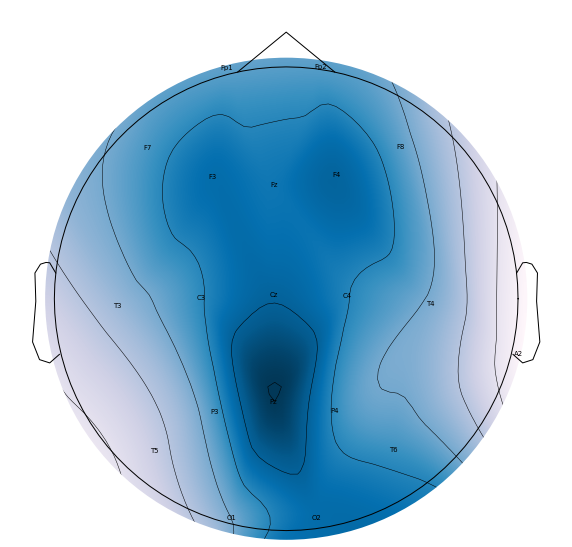

In [224]:
normalised_pos = normalise_layout_pos(layout)

video_file_names = [gen_topomap_video(bp2['sam']['meditation'][band], normalised_pos, f"{band}-{subject}-{recording_type}-{recording_id}") for b in cfg['bands'].keys()]

In [337]:
band = 'alpha'
_tn, frames = gen_topomap_video(bp2['sam']['meditation'][band], normalised_pos, f"{band}-{subject}-{recording_type}-{recording_id}", fraction_to_plot=0.001)

display_video(_tn)

In [338]:
_tn = gen_topomap_video(_theta / _gamma, normalised_pos, f"theta_over_gamma-{subject}-{recording_type}-{recording_id}", fraction_to_plot=0.001)

In [341]:
display_video(_tn[0])

In [349]:
bp2['sam']['meditation'].keys()

dict_keys([0, 'gamma', 'beta', 'alpha', 'theta', 'delta'])

In [378]:
def gen_topomap_frames_all_bands(data_all_bands, times_index_to_plot, pos, cmap='PuBu', fraction_to_plot=0.01):
    # create OpenCV video writer
    
    
    bandpower_over_time_index = data_all_bands[list(data_all_bands.keys())[0]].index
    n_plots = np.int(bandpower_over_time_index.shape[0] * fraction_to_plot) # // cfg['sampling_frequency']
    times_index_to_plot = np.linspace(start=0, stop=bandpower_over_time_index.shape[0] - 1, num=n_plots, dtype=np.int)
    
    frames = []
    
    scalar_mappable_for_band = {b: cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=data.min().min(), 
                                                                               vmax=data.max().max()), 
                                                     cmap=cmap) 
                                for b, data in data_all_bands.items()}    
    n_cols = len(scalar_mappable_for_band.keys())
    # loop over your images
    for idx, time_index in enumerate(times_index_to_plot):
        fig, axs = plt.subplots(nrows=1, ncols=n_cols, figsize=(10 * n_cols, 10))
        for ax_idx, (band, data) in enumerate(data_all_bands.items()):
            viz.plot_topomap(data.iloc[time_index, :].T.values, 
                             cmap=cmap,
                             sphere=1.,
                             pos=pos,
                             axes=axs[ax_idx],
                             sensors=False,
                             show_names=True,
                             show=False,
                             names=data.columns)

            axs[ax_idx].set_title(f"{band}: {index_to_time(times_index_to_plot[idx], bandpower_over_time_index)}")
        
            # notice that this will create some weird plot if you plot it interactively... no idea why
            fig.colorbar(sm, ax=axs[ax_idx], orientation='vertical')

        plt.tight_layout()        
        
        # this has to be the last thing
        fig.canvas.draw()

        mat = np.array(fig.canvas.renderer._renderer)
        #mat = cv2.cvtColor(mat, cv2.COLOR_RGB2BGR)

        frames.append(mat)        
    
        plt.close()

    return frames

In [367]:
data_for_all_bands = {b: bp2['sam']['meditation'][b] for b in cfg['bands'].keys()}

In [ ]:
frames = gen_topomap_frames_all_bands(data_for_all_bands, times_index_to_plot, normalised_pos, fraction_to_plot=0.01)

save_frames(frames, 'all_bands.mp4')

In [ ]:
display_video('all_bands.mp4')

In [ ]:
stop

In [350]:
def gen_topomap_video_all(data, normalised_pos, title, fraction_to_plot= 0.01):
    n_plots = np.int(data.shape[0] * fraction_to_plot) # // cfg['sampling_frequency']
    bandpower_over_time_index = data.index
    times_index_to_plot = np.linspace(start=0, stop=bandpower_over_time_index.shape[0] - 1, num=n_plots, dtype=np.int)
    
    frames = gen_topomap_frames(data=data,
                                times_index_to_plot=times_index_to_plot,
                                pos=normalised_pos,
                                title=title)

    movie_file_name = f"{title}.mp4"
    save_frames(frames, movie_file_name)
    return movie_file_name

In [ ]:
stop

In [ ]:
meditation_bandpower = get_bandpower_for_electrode(meditation_pd, electrode=electrode_of_interest, config=cfg)
baseline_bandpower   = get_bandpower_for_electrode(baseline_pd, electrode=electrode_of_interest, config=cfg)

In [ ]:
# for each of the evoked chanels
meditation_bandpower = pd.DataFrame(meditation_bandpower)

In [ ]:
bandpower_adelie = {
    'baseline': get_bandpower_for_electrode(baseline_adelie_pd, electrode=electrode_of_interest, config=cfg),
    'meditation': get_bandpower_for_electrode(meditation_adelie_pd, electrode=electrode_of_interest, config=cfg)
}

In [ ]:
plot_raw_signal(baseline_pd);

In [ ]:
plot_raw_signal(meditation_pd);

In [ ]:
plot_bandpowers(baseline_bandpower, electrode=electrode_of_interest);

In [ ]:
plot_bandpowers(meditation_bandpower, electrode=electrode_of_interest);

In [ ]:
aggregated_power_adelie = aggregate_bandpower(baseline=bandpower_adelie['baseline'], signal=bandpower_adelie['meditation'])
aggregated_power_adelie

In [ ]:
aggregated_power_sam = aggregate_bandpower(baseline=baseline_bandpower, signal=meditation_bandpower)
aggregated_power_sam

## spectrogram videos

In [ ]:
ls ../../data/AlphaTheta/sam-AlphaTheta/offline/fif

In [ ]:
fif_meditation = load_raw_mne_from_fif('meditation', subject='sam', config=cfg)

In [ ]:
meditation_csd = mne.preprocessing.compute_current_source_density(fif_meditation)

In [ ]:
meditation_csd.plot(scalings='auto')
meditation_csd.plot_psd()

In [ ]:
def raw_to_epochs(raw, events, sampling_frequency, weird_epoch_offset=100):
    return mne.Epochs(raw=raw, events=events, tmax=events[-1, 0] * 1 / sampling_frequency - weird_epoch_offset).average()

In [ ]:
signals_meditation, events_meditation = load_raw_mne_from_fif('meditation', subject='sam', config=cfg)
signals_baseline, events_baseline = load_raw_mne_from_fif('baseline', subject='sam', config=cfg)

In [ ]:
signals_baseline.plot_sensors(show_names=True)

In [ ]:
epochs_meditation = raw_to_epochs(raw=signals_meditation, events=events_meditation, sampling_frequency=cfg['sampling_frequency'])
epochs_meditation.plot_topomap()

In [ ]:
epochs_baseline = raw_to_epochs(raw=signals_baseline, events=events_baseline, sampling_frequency=cfg['sampling_frequency'])
epochs_baseline.plot_topomap()

In [ ]:
epochs_baseline.info

In [ ]:
def plot_topomap_over_time(title, epochs, events, sampling_frequency, n_plots=64, weird_epoch_offset=100):
    last_frame_in_seconds = np.floor(events[-1, 0] * 1 / sampling_frequency - weird_epoch_offset)
    all_times = np.linspace(0, last_frame_in_seconds, n_plots)
    return epochs.plot_topomap(all_times, ch_type='eeg', time_unit='s', ncols=8, nrows='auto', title=title)

In [ ]:
plot_topomap_over_time(epochs=epochs_baseline,
                       events=events_baseline,
                       sampling_frequency=cfg['sampling_frequency'],
                       title='baseline')

In [ ]:
plot_topomap_over_time(epochs=epochs_meditation,
                       events=events_meditation,
                       sampling_frequency=cfg['sampling_frequency'],
                       title='meditation')

In [ ]:
def epochs_to_animation(file_name, epochs, events, sampling_frequency, n_frames, weird_offset=100):
    to_file_parameters = {'show': False, 'blit': False}

    #fig, anim = epochs.animate_topomap(ch_type='eeg', times=np.arange(0, 40 events[-1, 0] * 1 / cfg['sampling_frequency'] - 10, 0.5),  butterfly=True)
    fig, anim = epochs.animate_topomap(ch_type='eeg', 
                                       times=np.linspace(0, events[-1, 0] * 1 / sampling_frequency - weird_offset, n_frames),
                                       butterfly=True, 
                                       **to_file_parameters)
    anim.save(f"{file_name}.mp4")

In [ ]:
epochs_to_animation('baseline', 
                    epochs=epochs_baseline,
                    events=events_baseline,
                    sampling_frequency=cfg['sampling_frequency'],
                    n_frames=10)

In [ ]:
epochs_to_animation('meditation', 
                    epochs=epochs_meditation,
                    events=events_meditation,
                    sampling_frequency=cfg['sampling_frequency'],
                    n_frames=10)

In [ ]:
stop

In [ ]:
reject = dict(eeg=180e-6, eog=150e-6)
event_id, tmin, tmax = {'left/auditory': 1}, -0.2, 0.5
events = mne.read_events(event_fname)
epochs_params = dict(events=events, event_id=event_id, tmin=tmin, tmax=tmax,
                     reject=reject)

evoked_no_ref = mne.Epochs(raw, **epochs_params).average()

title = 'EEG Original reference'
evoked_no_ref.plot(titles=dict(eeg=title), time_unit='s')
evoked_no_ref.plot_topomap(times=[0.1], size=3., title=title, time_unit='s')

## 

## 

# Graveyard, not interesting below here

In [ ]:
sampling_rate = 300
window_size = 4 * sampling_rate # in seconds

plt.figure(figsize=(24, 10))
for c in [c for c in signals_pd.columns if c not in ['TRIGGER', 'X1', 'X2', 'X3', 'A2']]:
    freqs, psd = signal.welch(signals_pd.loc[:, c], sampling_rate, nperseg=window_size)

    plt.plot(freqs, psd, label=c)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density (V^2 / Hz)')
    #plt.ylim([0, psd.max() * 1.1])
    plt.title("Welch's periodogram")
    #plt.xlim([0, freqs.max()])
    plt.xlim([0, 20])
    sns.despine()
    
plt.legend();

In [ ]:
# for a window size of... compute the power and compare it over time



bandpower(signals_pd.loc[:, 'T5'], 300., cfg['bands']['theta'])

In [ ]:
signals = baseline['signals']
fig, axs = plt.subplots(nrows=signals.shape[1], figsize=(40, 1.4 * signals.shape[1]))
for channel in range(signals.shape[1]):
    sns.lineplot(data=signals[::10, channel], ax=axs[channel], )
    axs[channel].set_ylabel(baseline['ch_names'][channel])
    
axs[-1].set_xlabel('time [ms]');

In [ ]:
38052/60